# Electron Photon tagging

This is a first test to implement a QAE and compare it to a classical AE.  
The task is to identify Electrons and Photons from em-calorimeter images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses

import warnings
warnings.filterwarnings('ignore')

2022-06-28 15:46:27.254350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 15:46:27.254379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-28 15:46:29.287874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-28 15:46:29.287910: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-28 15:46:29.287936: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-28 15:46:29.288263: I tensorflow/core/platform/cpu_fe

In [2]:
data = np.load('../../data/electron-photon.npz', allow_pickle=True)

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

maxx = np.max(x_train)
minn = np.min(x_train)

x_train = x_train / maxx
x_test = x_test / maxx

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (100, 32, 32)
x_test:  (100, 32, 32)
y_train:  (100,)
y_test:  (100,)


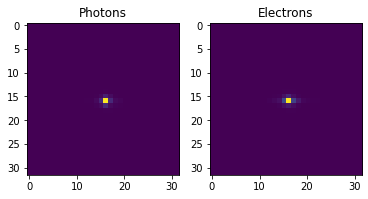

In [3]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_train[y_train==0],0))
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(x_train[y_train==1],0))
axs[1].title.set_text('Electrons')

In [4]:
x_train = x_train.reshape(-1, x_train.shape[-1]*x_train.shape[-2])
x_test = x_test.reshape(-1, x_test.shape[-1]*x_test.shape[-2])

In [5]:
num_data, input_dim = x_train.shape

In [6]:
latent_dim = 1
ae = cae.Autoencoder(input_dim, latent_dim)

In [7]:
ae.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.05))

In [8]:
ae.build(x_train.shape)
ae.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 1025      
                                                                 
 sequential_1 (Sequential)   (100, 1024)               2048      
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [9]:
x_train_e = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_e = x_test[y_test==1]
x_test = x_test[y_test==0]

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
hist = ae.fit(x_train, x_train,
                epochs=5000,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[es])

Epoch 1/5000
2/2 [==============================] - 1s 165ms/step - loss: 0.2461 - val_loss: 0.2254
Epoch 2/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.2223 - val_loss: 0.2027
Epoch 3/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.1997 - val_loss: 0.1814
Epoch 4/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.1787 - val_loss: 0.1618
Epoch 5/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.1593 - val_loss: 0.1438
Epoch 6/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.1415 - val_loss: 0.1275
Epoch 7/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.1254 - val_loss: 0.1129
Epoch 8/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.1110 - val_loss: 0.0998
Epoch 9/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0982 - val_loss: 0.0883
Epoch 10/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0868 - val_loss: 0.0781
Epoch 11

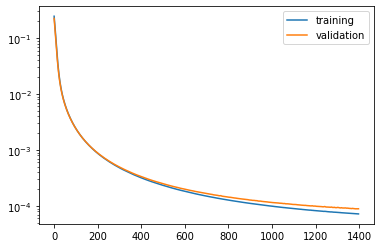

In [11]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [12]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=1)

def recon_acc(x):
    return 1 - mae(x)

def IF(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x*pred,axis=(1,2))
def IF2(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x**2,axis=(1,2))

In [13]:
photons = recon_acc(x_test)
electrons = recon_acc(x_test_e)

0.9999151
0.9999305


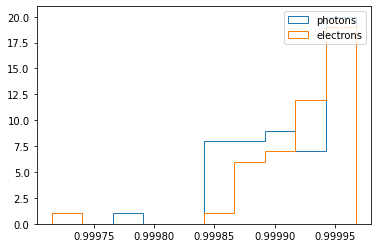

In [14]:
print(np.median(photons))
bins = np.histogram(np.hstack((photons, electrons)), bins=10)[1]
plt.hist(photons, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(electrons))
plt.hist(electrons, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

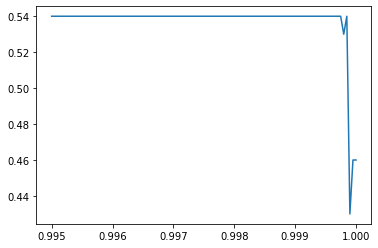

In [15]:
def acc_for_threshold(T):
    # sixes that are predicted photon
    num_six_right = np.sum(photons > T)
    # threes that are predicted three
    num_three_right = np.sum(electrons < T)
   
    acc = (num_six_right + num_three_right)/(len(photons) + len(electrons))
    return acc

Ts = np.linspace(0.995,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs) 